In [35]:
!pip install xgboost

     |████████████████████████████████| 166.7 MB 14 kB/s s eta 0:00:01


# Iowa Liquor Sales - Forecasting Time Series Retail Data using XGBoost
by Jeanna Schoonmaker, May 2021

### How effectively can a trained model predict retail sales of liquor for a store in the state of Iowa? 

#### Data used for this project: 
Iowa Liquor Sales, available as a public dataset on Google's BigQuery, or here: https://data.iowa.gov/Sales-Distribution/Iowa-Liquor-Sales/m3tr-qhgy

#### EDA Questions explored:
1. Which store or chain of stores sold the most alcohol (by total dollar amount of sales) in 2019 and 2020?
2. What are the highest purchased items, and highest purchased categories (by total dollar amount of slaes) at Hy-Vee locations in Iowa for 2020?
3. For the Hy-Vee location in Cedar Falls, which month, days of the month, and days of the week had the highest sales totals (measured in dollars) for 2020?

#### Model Questions explored:
1. Once add'l date features, daily, weekly, and monthly averages are added, which features correlate most strongly with sales amount in dollars?
2. When an XGBoost model is trained on the 2020 data for the Hy-Vee in Cedar Falls, how accurate can it forecast the 2021 sales data?


In [234]:
import pandas as pd
import numpy as np
import xgboost as xgb
import datetime as dt
from sklearn.metrics import mean_squared_error

In [235]:
%%bigquery
SELECT sum(bottles_sold) as bottles, round(sum(sale_dollars), 2) as sales_amt_in_dollars, 
CASE
    WHEN store_name LIKE "%Hy-_ee%" THEN 'Hy-Vee'
    WHEN store_name LIKE '%Wal-Mart%' THEN 'Wal-Mart'
    WHEN store_name LIKE '%Sam%' THEN 'Sam"s Club'
    WHEN store_name LIKE '%Kum%' THEN 'Kum & Go'
    WHEN store_name LIKE '%KUM%' THEN 'Kum & Go'
    WHEN store_name LIKE '%Casey%' THEN 'Casey"s'
    WHEN store_name LIKE '%Fareway%' THEN 'Fareway'
    WHEN store_name LIKE '%Smokin%' THEN 'Smokin Joe"s'
    WHEN store_name LIKE '%Target%' THEN 'Target'
    WHEN store_name LIKE '%Central%' THEN 'Central City'
    WHEN store_name LIKE '%Costco%' THEN 'Costco'
    ELSE 'Other'
END AS STORE
FROM `bigquery-public-data.iowa_liquor_sales.sales` 
WHERE date BETWEEN DATE(2020, 01, 01) AND DATE(2020, 12, 31)
GROUP BY 3
ORDER BY sales_amt_in_dollars DESC

Downloading: 100%|██████████| 11/11 [00:01<00:00, 10.70rows/s]


,bottles,sales_amt_in_dollars,STORE
0,9133160,1.367149e+08,Hy-Vee
1,11839679,1.320490e+08,Other
2,1834659,2.987526e+07,Fareway
3,1458762,2.346572e+07,Wal-Mart
4,1368106,2.271403e+07,"Sam""s Club"
5,1842826,1.779888e+07,"Casey""s"
6,677121,1.138480e+07,Central City
7,400695,8.405628e+06,Costco
8,690889,7.206743e+06,Kum & Go
9,250031,4.748640e+06,Target


For the year 2020, which stores in Iowa had the most liquor sales by dollar amount?

Hy-Vee is the frontrunner for 2020. I was curious - with 2020 being an outlier in so many ways, would the numbers be different for 2019? Were more people picking up liquor at the grocery store simply because other businesses might not have been as convenient, or had as many hours of availability due to covid? 

I decided to run the query for 2019, just to check.

In [236]:
%%bigquery
SELECT sum(bottles_sold) as bottles, round(sum(sale_dollars), 2) as sales_amt_in_dollars, 
CASE
    WHEN store_name LIKE "%Hy-_ee%" THEN 'Hy-Vee'
    WHEN store_name LIKE '%Wal-Mart%' THEN 'Wal-Mart'
    WHEN store_name LIKE '%Sam%' THEN 'Sam"s Club'
    WHEN store_name LIKE '%Kum%' THEN 'Kum & Go'
    WHEN store_name LIKE '%KUM%' THEN 'Kum & Go'
    WHEN store_name LIKE '%Casey%' THEN 'Casey"s'
    WHEN store_name LIKE '%Fareway%' THEN 'Fareway'
    WHEN store_name LIKE '%Smokin%' THEN 'Smokin Joe"s'
    WHEN store_name LIKE '%Target%' THEN 'Target'
    WHEN store_name LIKE '%Central%' THEN 'Central City'
    WHEN store_name LIKE '%Costco%' THEN 'Costco'
    ELSE 'Other'
END AS STORE
FROM `bigquery-public-data.iowa_liquor_sales.sales` 
WHERE date BETWEEN DATE(2019, 01, 01) AND DATE(2019, 12, 31)
GROUP BY 3
ORDER BY sales_amt_in_dollars DESC

Downloading: 100%|██████████| 11/11 [00:01<00:00, 10.71rows/s]


,bottles,sales_amt_in_dollars,STORE
0,8603331,1.249759e+08,Hy-Vee
1,10615224,1.148086e+08,Other
2,1492793,2.325197e+07,Fareway
3,1477662,2.264168e+07,Wal-Mart
4,1238872,2.061606e+07,"Sam""s Club"
5,845578,1.430020e+07,Central City
6,1198662,1.136237e+07,"Casey""s"
7,552310,6.019449e+06,Kum & Go
8,274740,5.777393e+06,Costco
9,180780,3.278435e+06,Target


Even in a non-pandemic year, Hy-Vee is at the top by sales amount of liquor in dollars - it's worth noting that other locations actually sell more when measured by bottles.

Now that it's clear Hy-Vee is a regular leader at liquor sales in Iowa, I'm going to drill down and take a look at liquor sales at all Hy-Vee locations in 2020 to find out the most commonly purchased items both by item description and by category.

In [237]:
%%bigquery
SELECT sum(bottles_sold) as bottles_sold, round(sum(sale_dollars), 2) as sales_amt_in_dollars, count(bottles_sold) as count_of_sales, item_description, category_name
FROM `bigquery-public-data.iowa_liquor_sales.sales` 
WHERE date BETWEEN DATE(2020, 01, 01) AND DATE(2020, 12, 31) AND store_name LIKE '%Hy-_ee%'
GROUP BY item_description, category_name
ORDER BY sales_amt_in_dollars DESC

Downloading: 100%|██████████| 2900/2900 [00:01<00:00, 2609.18rows/s]


,bottles_sold,sales_amt_in_dollars,count_of_sales,item_description,category_name
0,422254,8496343.30,10452,Titos Handmade Vodka,American Vodkas
1,272978,3420971.72,9192,Black Velvet,Canadian Whiskies
2,130224,3337415.92,6915,Crown Royal,Canadian Whiskies
3,114954,3140458.15,5907,Jack Daniels Old #7 Black Label,Tennessee Whiskies
4,686327,2566113.62,9630,Fireball Cinnamon Whiskey,Whiskey Liqueur
...,...,...,...,...,...
2895,1,21.26,1,Aviation American Gin w/Martini Glasses,Temporary & Specialty Packages
2896,1,21.03,1,River Baron Artisian Spirit DISCO,American Vodkas
2897,1,17.82,1,Ketel One Botanical Cucumber & Mint Mini,Imported Flavored Vodka
2898,1,15.96,1,Colville Small Batch 5YR Kentucky Straight Bou...,Straight Bourbon Whiskies


The most common liquor item sold in Hy-Vees in Iowa in 2020 by dollar amount was Titos Handmade Vodka. Fireball Cinnamon Whiskey had almost 260k more bottles sold, but roughly only 1/3 of the sales amount in dollars. 

In [238]:
%%bigquery
SELECT sum(bottles_sold) as bottles, round(sum(sale_dollars), 2) as sales_amt_in_dollars, count(sale_dollars) as count_of_sales, category_name
FROM `bigquery-public-data.iowa_liquor_sales.sales` 
WHERE date BETWEEN DATE(2020, 01, 01) AND DATE(2020, 12, 31) AND store_name LIKE '%Hy-_ee%'
GROUP BY category_name
ORDER BY sales_amt_in_dollars DESC

Downloading: 100%|██████████| 55/55 [00:00<00:00, 56.90rows/s]


,bottles,sales_amt_in_dollars,count_of_sales,category_name
0,1607510,19042514.60,92220,American Vodkas
1,627932,13539374.12,62052,Straight Bourbon Whiskies
2,803194,13282603.66,56384,Canadian Whiskies
3,417786,7238647.69,27839,Spiced Rum
4,368113,6411359.00,24404,Imported Vodkas
5,927413,6257297.40,31614,Whiskey Liqueur
6,239709,6071798.57,30475,100% Agave Tequila
7,204887,5012724.60,17880,Tennessee Whiskies
8,313043,4639532.36,36075,Blended Whiskies
9,353881,4030989.58,43181,American Flavored Vodka


Having this general information and seeing these trends, I now plan to drill down to investigate the liquor sales in a particular Hy-Vee store - the one in Cedar Falls.

In [239]:
%%bigquery
SELECT CASE
    WHEN extract(month from date) = 1 THEN 'Jan'
    WHEN extract(month from date) = 2 THEN 'Feb'
    WHEN extract(month from date) = 3 THEN 'Mar'
    WHEN extract(month from date) = 4 THEN 'Apr'
    WHEN extract(month from date) = 5 THEN 'May'
    WHEN extract(month from date) = 6 THEN 'Jun'
    WHEN extract(month from date) = 7 THEN 'Jul'
    WHEN extract(month from date) = 8 THEN 'Aug'
    WHEN extract(month from date) = 9 THEN 'Sep'
    WHEN extract(month from date) = 10 THEN 'Oct'
    WHEN extract(month from date) = 11 THEN 'Nov'
    WHEN extract(month from date) = 12 THEN 'Dec'
END AS MONTH, extract(month from date) as month_num, sum(bottles_sold) as bottles_sold, round(sum(sale_dollars), 2) as sales_amt_in_dollars, count(sale_dollars) as count_of_sales,
FROM `bigquery-public-data.iowa_liquor_sales.sales` 
WHERE date BETWEEN DATE(2020, 01, 01) AND DATE(2020, 12, 31) AND store_name LIKE '%Hy-Vee Food Store / Cedar%'
GROUP BY month_num, month
order by month_num

Downloading: 100%|██████████| 12/12 [00:01<00:00, 11.23rows/s]


,MONTH,month_num,bottles_sold,sales_amt_in_dollars,count_of_sales
0,Jan,1,4403,62269.49,949
1,Feb,2,9859,169013.52,1104
2,Mar,3,5897,93241.20,1115
3,Apr,4,8277,125555.70,1413
4,May,5,7912,127730.73,1301
5,Jun,6,8641,139941.91,1570
6,Jul,7,5952,91235.33,1184
7,Aug,8,5812,94001.96,1254
8,Sep,9,8704,147500.75,1515
9,Oct,10,13072,235546.60,1229


In [240]:
%%bigquery
SELECT extract(day from date) as day_of_month, sum(bottles_sold) as bottles_sold, round(sum(sale_dollars), 2) as sales_amt_in_dollars, count(sale_dollars) as count_of_sales
FROM `bigquery-public-data.iowa_liquor_sales.sales` 
WHERE date BETWEEN DATE(2020, 01, 01) AND DATE(2020, 12, 31) AND store_name LIKE '%Hy-Vee Food Store / Cedar%'
GROUP BY day_of_month
order by day_of_month

Downloading: 100%|██████████| 30/30 [00:01<00:00, 23.89rows/s]


,day_of_month,bottles_sold,sales_amt_in_dollars,count_of_sales
0,1,3369,57782.42,478
1,2,3017,47014.72,599
2,3,3671,55423.32,577
3,4,2419,37964.13,532
4,5,2964,44313.40,310
5,6,2470,45797.26,324
6,7,4861,71937.00,862
7,8,1681,26715.16,349
8,9,2674,41828.45,580
9,10,1360,23158.76,304


In [241]:
%%bigquery
SELECT extract(dayofweek from date) as weekday, sum(bottles_sold) as bottles_sold, round(sum(sale_dollars), 2) as sales_amt_in_dollars, count(sale_dollars) as count_of_sales,
CASE
    WHEN extract(dayofweek from date) = 1 THEN 'Sunday'
    WHEN extract(dayofweek from date) = 2 THEN 'Monday'
    WHEN extract(dayofweek from date) = 3 THEN 'Tuesday'
    WHEN extract(dayofweek from date) = 4 THEN 'Wednesday'
    WHEN extract(dayofweek from date) = 5 THEN 'Thursday'
    WHEN extract(dayofweek from date) = 6 THEN 'Friday'
    WHEN extract(dayofweek from date) = 7 THEN 'Saturday'
END AS day_of_week
FROM `bigquery-public-data.iowa_liquor_sales.sales` 
WHERE date BETWEEN DATE(2020, 01, 01) AND DATE(2020, 12, 31) AND store_name LIKE '%Hy-Vee Food Store / Cedar%'
GROUP BY weekday, day_of_week
order by weekday

Downloading: 100%|██████████| 5/5 [00:01<00:00,  2.94rows/s]


,weekday,bottles_sold,sales_amt_in_dollars,count_of_sales,day_of_week
0,2,847,13906.07,118,Monday
1,3,84076,1380365.75,13586,Tuesday
2,4,6015,97545.16,1142,Wednesday
3,5,2419,34913.21,526,Thursday
4,6,876,20322.24,3,Friday


In [242]:
%%bigquery cf_hyvee_2020
SELECT date, round(sum(sale_dollars), 2) as sales_amt_in_dollars
FROM `bigquery-public-data.iowa_liquor_sales.sales` 
WHERE date BETWEEN DATE(2020, 01, 01) AND DATE(2020, 12, 31) AND store_name LIKE '%Hy-Vee Food Store / Cedar%'
GROUP BY date
order by date

Downloading: 100%|██████████| 58/58 [00:00<00:00, 60.66rows/s] 


In [243]:
cf_hyvee_2020.head(10)

,date,sales_amt_in_dollars
0,2020-01-07,16114.86
1,2020-01-14,720.21
2,2020-01-15,8501.32
3,2020-01-21,14465.72
4,2020-01-28,22467.38
5,2020-02-04,16345.09
6,2020-02-11,23558.51
7,2020-02-18,20745.20
8,2020-02-25,108364.72
9,2020-03-03,16366.90


It is worth noting that this dataset does not reflect individual consumer purchases, but rather the product purchases for the Cedar Falls Hy-Vee store. The dataset's website at https://data.iowa.gov/Sales-Distribution/Iowa-Liquor-Sales/m3tr-qhgy lists that each row is an individual product purchase, but the date behavior of orders occurring roughly weekly indicates a store's purchasing schedule. It is also suspicious that no product purchases occur on weekends according to the weekday query, and by FAR the vast majority of purchases occur on a Tuesday.

## Next steps:
Using 2020's data as the training set, I plan to create a forecast for 2021 sales (test) using an XGBoost model. I will then compare the predictions for 2021 sales against the actual 2021 data (Jan 1st through April 30th) to measure how well the model performs.

Code inspired by Samir Saci in this article: https://towardsdatascience.com/machine-learning-for-store-demand-forecasting-and-inventory-optimization-part-1-xgboost-vs-9952d8303b48

In [244]:
%%bigquery cf_hyvee_2021
SELECT date, round(sum(sale_dollars), 2) as sales_amt_in_dollars
FROM `bigquery-public-data.iowa_liquor_sales.sales` 
WHERE date BETWEEN DATE(2021, 01, 01) AND DATE(2021, 04, 30) AND store_name LIKE '%Hy-Vee Food Store / Cedar%'
GROUP BY date
order by date

Downloading: 100%|██████████| 18/18 [00:01<00:00,  9.66rows/s]


In [245]:
cf_hyvee_2021.head(5)

,date,sales_amt_in_dollars
0,2021-01-05,24810.54
1,2021-01-14,18556.78
2,2021-01-21,25878.26
3,2021-01-28,29038.79
4,2021-02-04,18141.38


In [246]:
train = cf_hyvee_2020
test = cf_hyvee_2021

In [247]:
def date_features(df):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.day
    df['dayofyear'] = df.date.dt.dayofyear
    df['dayofweek'] = df.date.dt.dayofweek + 1 # to make the number match format where Monday=1, Tuesday=2, etc.
    df['weekofyear'] = df.date.dt.weekofyear
    return df

# Dates Features for Train, Test
train, test = date_features(train), date_features(test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [248]:
train

,date,sales_amt_in_dollars,year,month,day,dayofyear,dayofweek,weekofyear
0,2020-01-07,16114.86,2020,1,7,7,2,2
1,2020-01-14,720.21,2020,1,14,14,2,3
2,2020-01-15,8501.32,2020,1,15,15,3,3
3,2020-01-21,14465.72,2020,1,21,21,2,4
4,2020-01-28,22467.38,2020,1,28,28,2,5
5,2020-02-04,16345.09,2020,2,4,35,2,6
6,2020-02-11,23558.51,2020,2,11,42,2,7
7,2020-02-18,20745.20,2020,2,18,49,2,8
8,2020-02-25,108364.72,2020,2,25,56,2,9
9,2020-03-03,16366.90,2020,3,3,63,2,10


In [249]:
# Adding in the daily, weekly, and monthly average to the train and test sets, then dropping any empty rows
train['daily_avg']  = train.groupby(['dayofweek'])['sales_amt_in_dollars'].transform('mean')
train['monthly_avg'] = train.groupby(['month'])['sales_amt_in_dollars'].transform('mean')
train['weekly_avg'] = train.groupby(['weekofyear'])['sales_amt_in_dollars'].transform('mean')
train = train.dropna()

In [250]:
test['daily_avg']  = test.groupby(['dayofweek'])['sales_amt_in_dollars'].transform('mean')
test['monthly_avg'] = test.groupby(['month'])['sales_amt_in_dollars'].transform('mean')
test['weekly_avg'] = test.groupby(['weekofyear'])['sales_amt_in_dollars'].transform('mean')
test = test.dropna()

In [251]:
train.head(10)

,date,sales_amt_in_dollars,year,month,day,dayofyear,dayofweek,weekofyear,daily_avg,monthly_avg,weekly_avg
0,2020-01-07,16114.86,2020,1,7,7,2,2,27607.315,12453.898,16114.860
1,2020-01-14,720.21,2020,1,14,14,2,3,27607.315,12453.898,4610.765
2,2020-01-15,8501.32,2020,1,15,15,3,3,24386.290,12453.898,4610.765
3,2020-01-21,14465.72,2020,1,21,21,2,4,27607.315,12453.898,14465.720
4,2020-01-28,22467.38,2020,1,28,28,2,5,27607.315,12453.898,22467.380
5,2020-02-04,16345.09,2020,2,4,35,2,6,27607.315,42253.380,16345.090
6,2020-02-11,23558.51,2020,2,11,42,2,7,27607.315,42253.380,23558.510
7,2020-02-18,20745.20,2020,2,18,49,2,8,27607.315,42253.380,20745.200
8,2020-02-25,108364.72,2020,2,25,56,2,9,27607.315,42253.380,108364.720
9,2020-03-03,16366.90,2020,3,3,63,2,10,27607.315,18648.240,16366.900


In [252]:
test.tail(10)

,date,sales_amt_in_dollars,year,month,day,dayofyear,dayofweek,weekofyear,daily_avg,monthly_avg,weekly_avg
8,2021-03-04,16614.69,2021,3,4,63,4,9,26737.07875,16825.860,16614.69
9,2021-03-09,3114.54,2021,3,9,68,2,10,13962.54000,16825.860,11992.84
10,2021-03-11,20871.14,2021,3,11,70,4,10,26737.07875,16825.860,11992.84
11,2021-03-18,14043.95,2021,3,18,77,4,11,26737.07875,16825.860,14043.95
12,2021-03-25,29484.98,2021,3,25,84,4,12,26737.07875,16825.860,29484.98
13,2021-04-01,16227.86,2021,4,1,91,4,13,26737.07875,21462.978,16227.86
14,2021-04-08,29512.02,2021,4,8,98,4,14,26737.07875,21462.978,29512.02
15,2021-04-15,19436.79,2021,4,15,105,4,15,26737.07875,21462.978,19436.79
16,2021-04-22,22633.90,2021,4,22,112,4,16,26737.07875,21462.978,22633.90
17,2021-04-29,19504.32,2021,4,29,119,4,17,26737.07875,21462.978,19504.32


### Visualizing the features in a triangle correlation heatmap

In [253]:
import seaborn as sns
import matplotlib.pyplot as plt

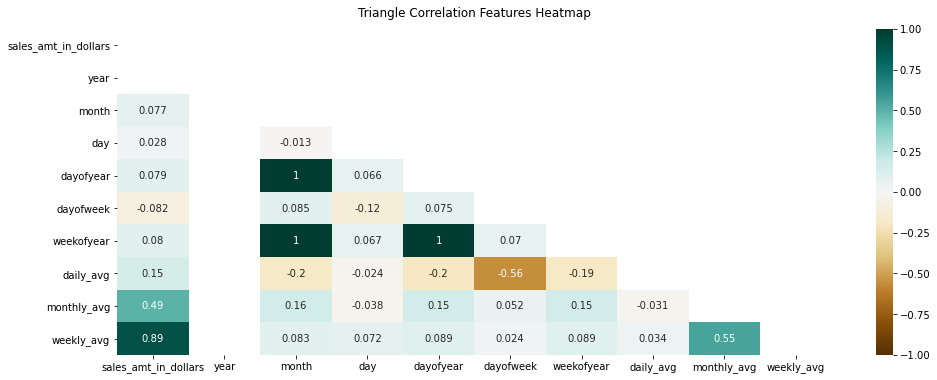

In [254]:
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(train.corr(), dtype=np.bool))
heatmap = sns.heatmap(train.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Features Heatmap', fontdict={'fontsize':12}, pad=12);

### Adding an add'l visualization clearly showing which features have the highest correlation with sales amount.

Credit for the code for these visualizations from this article by Bibor Szabo: https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e

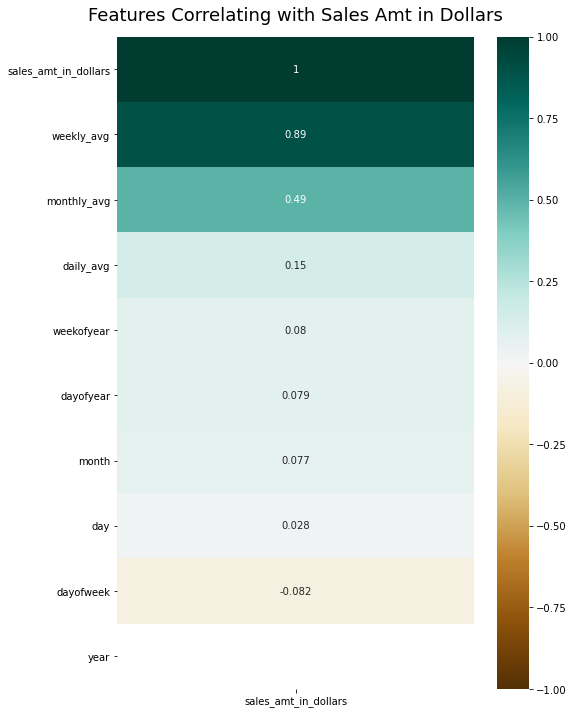

In [255]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(train.corr()[['sales_amt_in_dollars']].sort_values(by='sales_amt_in_dollars', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Sales Amt in Dollars', fontdict={'fontsize':18}, pad=16);

### From this, we can see that the weekly and monthly averages have the highest correlation with sales. I'll train the XGBoost model using them as the features and drop the others.

In [256]:
# dropping the unused features in train and test
for df in [train, test]:
    df.drop(['year', 
                  'dayofyear', 
                  'daily_avg',
                  'weekofyear',
                  'day',
                  'month',
                  'dayofweek',
                  'date'],
                 axis=1, 
                 inplace=True)

In [257]:
train.head(5)

,sales_amt_in_dollars,monthly_avg,weekly_avg
0,16114.86,12453.898,16114.860
1,720.21,12453.898,4610.765
2,8501.32,12453.898,4610.765
3,14465.72,12453.898,14465.720
4,22467.38,12453.898,22467.380


In [258]:
#prepping the data for model creation
train = (train - train.mean()) / train.std()
test = (test - test.mean()) / test.std()

In [259]:
X_train = train[['weekly_avg', 'monthly_avg']]
y_train = train['sales_amt_in_dollars']
X_test = test[['weekly_avg', 'monthly_avg']]
y_test = test['sales_amt_in_dollars']

In [260]:
matrix_train = xgb.DMatrix(X_train, label = y_train)
matrix_test = xgb.DMatrix(X_test, label = y_test)

### Model training

In [261]:
model = xgb.train(params={'objective':'reg:squarederror','eval_metric':'mae'}
                ,dtrain = matrix_train, num_boost_round = 500, 
                early_stopping_rounds=20, evals = [(matrix_test,'test')],)

[0]	test-mae:0.63424
[1]	test-mae:0.47335
[2]	test-mae:0.36264
[3]	test-mae:0.28291
[4]	test-mae:0.23090
[5]	test-mae:0.18846
[6]	test-mae:0.15943
[7]	test-mae:0.13634
[8]	test-mae:0.12111
[9]	test-mae:0.10780
[10]	test-mae:0.09617
[11]	test-mae:0.08786
[12]	test-mae:0.08265
[13]	test-mae:0.08554
[14]	test-mae:0.08830
[15]	test-mae:0.09013
[16]	test-mae:0.09241
[17]	test-mae:0.09408
[18]	test-mae:0.09565
[19]	test-mae:0.09708
[20]	test-mae:0.09838
[21]	test-mae:0.09924
[22]	test-mae:0.10029
[23]	test-mae:0.10080
[24]	test-mae:0.10163
[25]	test-mae:0.10231
[26]	test-mae:0.10272
[27]	test-mae:0.10290
[28]	test-mae:0.10328
[29]	test-mae:0.10353
[30]	test-mae:0.10356
[31]	test-mae:0.10375


### Visualization of predicted vs actual results from XGBoost model forecast

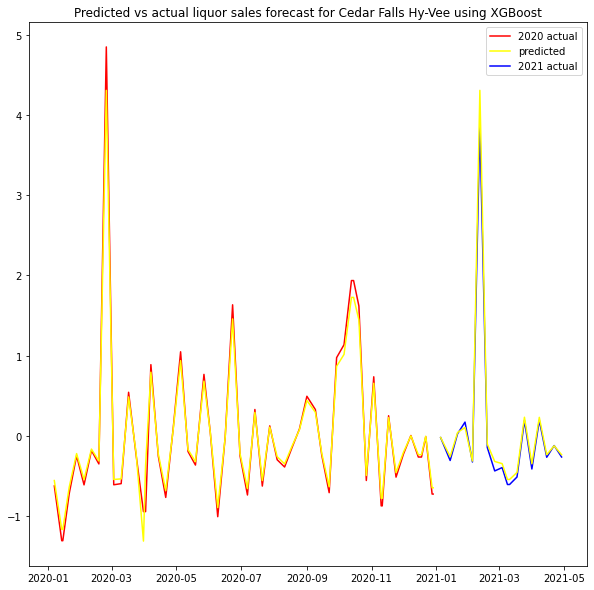

In [262]:
plt.figure(figsize=(10, 10))
plt.plot(cf_hyvee_2020['date'], X_train['weekly_avg'], color = "red", label='2020 actual')
plt.plot(cf_hyvee_2020['date'], model.predict(matrix_train), color = 'yellow', label='predicted')
plt.plot(cf_hyvee_2021['date'], test['weekly_avg'], color = "blue", label='2021 actual')
plt.plot(cf_hyvee_2021['date'], model.predict(matrix_test), color = "yellow")
plt.title("Predicted vs actual liquor sales forecast for Cedar Falls Hy-Vee using XGBoost")
plt.legend()

plt.show()

### As can be seen from the graph above and the >5% mean square error metric below, the XGBoost model performed well at forecasting the 2021 data

In [263]:
# checking metric for the model
mean_squared_error(y_test, model.predict(matrix_test))

0.03277522922346791

### Next steps:
1. It would be interesting to drill down and do specific item order forecasting as opposed to general sales forecasting.
2. This was all done for one specific Hy-Vee store, it could be expanded to other stores or a forecast for ALL Iowa Hy-Vees could be developed.
3. This used XGBoost, but I have heard great things about the Prophet forecasting package. It would also be useful to compare XGBoost's performance against other models.